In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import xarray as xr

In [2]:
import xesmf as xe
from xesmf import backend as xeb

import importlib
importlib.reload(xe)
importlib.reload(xeb)

<module 'xesmf.backend' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/backend.py'>

# Make grids

In [3]:
ds_in = xe.util.grid_global(5, 4)
ds_in

<xarray.Dataset>
Dimensions:  (x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [4]:
ds_out = xe.util.grid_global(2, 2)
ds_out

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 -167.0 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 -170 -168 -166 -164 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [5]:
sourcegrid = xe.util.ds_to_ESMFgrid(ds_in)
dstgrid = xe.util.ds_to_ESMFgrid(ds_out)

# Build regrid object

In [40]:
import os
os.remove('weights1.nc')

In [41]:
%%time 
regrid = xeb.esmf_regrid_build(sourcegrid, dstgrid, 'conservative',
                               filename='weights1.nc')

CPU times: user 779 ms, sys: 32.1 ms, total: 811 ms
Wall time: 815 ms


# Generate input data

In [51]:
ds_in['data'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])

In [52]:
ds_out['data_truth'] = xe.data.wave_smooth(ds_out['lon'], ds_out['lat'])

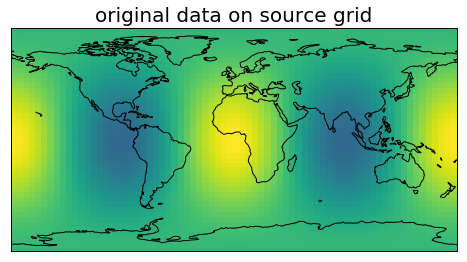

In [53]:
def plot_datafield(ax, ds, data):
    ax.pcolormesh(ds['lon_b'], ds['lat_b'], data,
                  vmin=0, vmax=3)
    ax.coastlines()

fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())

plot_datafield(ax, ds_in, ds_in['data'])
ax.set_global()
ax.set_title('original data on source grid', fontsize=20)

# Apply regridding

In [54]:
outdata = xeb.esmf_regrid_apply(regrid, ds_in['data'].values.T)
outdata.shape

(180, 90)

In [55]:
ds_out

<xarray.Dataset>
Dimensions:     (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon         (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 ...
    lat         (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b       (y_b, x_b) int64 -180 -178 -176 -174 -172 -170 -168 -166 ...
    lat_b       (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data_truth  (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    data        (y, x) float64 2.001 2.001 2.001 2.001 2.001 2.001 2.001 ...

In [56]:
ds_out['data'] = (['y', 'x'], outdata.T)

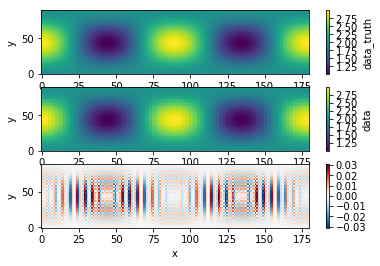

In [57]:
plt.subplot(311)
ds_out['data_truth'].plot()
plt.subplot(312)
ds_out['data'].plot()
plt.subplot(313)
rel_err = ((ds_out['data']-ds_out['data_truth'])/ds_out['data_truth'])
rel_err.plot()

In [58]:
np.abs(rel_err).max()

<xarray.DataArray ()>
array(0.03125723848053363)

In [59]:
rel_err.mean()

<xarray.DataArray ()>
array(7.750139904678574e-05)

# Free memory

In [60]:
xeb.esmf_regrid_finalize(regrid)

In [61]:
regrid.dstfield.data # data still exist

array([[  0.00000000e+000,   2.00122508e+000,   2.01088462e+000, ...,
          2.01088462e+000,   2.00122508e+000,   2.00121334e+000],
       [  2.00121334e+000,   2.00123290e+000,   2.01088462e+000, ...,
          2.01088462e+000,   2.00123290e+000,   2.00121334e+000],
       [  6.93624113e-310,   2.00120108e+000,   2.01071903e+000, ...,
          2.01071903e+000,   2.00120108e+000,   2.00119491e+000],
       ..., 
       [  2.00119491e+000,   2.00120108e+000,   2.01071903e+000, ...,
          2.01071903e+000,   2.00120108e+000,   2.00119491e+000],
       [  2.00121334e+000,   2.00123290e+000,   2.01088462e+000, ...,
          2.01088462e+000,   2.00123290e+000,   2.00121334e+000],
       [  2.00121334e+000,   2.00122508e+000,   2.01088462e+000, ...,
          2.01088462e+000,   2.00122508e+000,   2.00121334e+000]])

# Test broadcast

In [62]:
extra_dims = [50, 10] # lev, time

In [63]:
%%time
regrid_4D = xeb.esmf_regrid_build(sourcegrid, dstgrid, 
                                  'conservative', extra_dims=extra_dims)

CPU times: user 605 ms, sys: 12.3 ms, total: 617 ms
Wall time: 617 ms


In [64]:
# add time and level coordinates
ds_in.coords['time'] = np.arange(1, extra_dims[1]+1)
ds_in.coords['lev'] = np.arange(1, extra_dims[0]+1)
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x) float64 2.001 2.001 2.001 2.001 2.001 2.001 2.001 2.0 ...
    data4D   (time, lev, y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...

In [65]:
# let it increases linearly with time and lev to test broadcasting
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data']
ds_in # extra_dims needs to be reverted, since we will pass tranpose

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x) float64 2.001 2.001 2.001 2.001 2.001 2.001 2.001 2.0 ...
    data4D   (time, lev, y, x) float64 2.001 2.001 2.001 2.001 2.001 2.001 ...

In [66]:
%%time
outdata_4D = xeb.esmf_regrid_apply(regrid_4D, ds_in['data4D'].values.T).T

CPU times: user 104 ms, sys: 32.7 ms, total: 137 ms
Wall time: 135 ms


In [67]:
outdata_4D.shape

(10, 50, 90, 180)

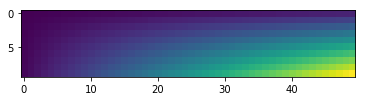

In [68]:
plt.imshow(outdata_4D.mean(axis=(2,3)))

# Use Scipy regridding

In [69]:
ds_in['lon'].size, ds_out['lon'].size

(3240, 16200)

In [70]:
import xesmf.smm as xes

import importlib
importlib.reload(xes)

<module 'xesmf.smm' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/smm.py'>

In [71]:
A = xes.read_weights("weights1.nc", ds_in['lon'].size, ds_out['lon'].size)

In [72]:
A.shape # N_out, N_in

(16200, 3240)

In [73]:
data4D_in = ds_in['data4D'].values

In [74]:
Nlat_out, Nlon_out = ds_out['lon'].shape
Nlat_out, Nlon_out

(90, 180)

In [75]:
%time outdata_scipy = xes.apply_weights(A, data4D_in, Nlon_out, Nlat_out)

CPU times: user 36.3 ms, sys: 28.3 ms, total: 64.6 ms
Wall time: 64.1 ms


In [76]:
outdata_scipy.shape

(10, 50, 90, 180)

In [77]:
np.allclose(outdata_scipy, outdata_4D)

True

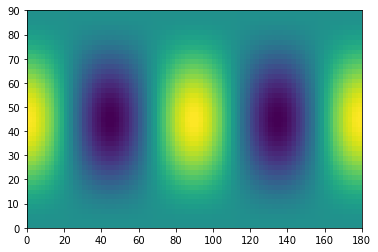

In [78]:
plt.pcolormesh(outdata_scipy.mean(axis=(0,1)))

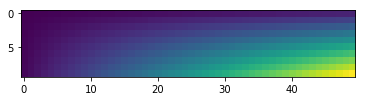

In [79]:
plt.imshow(outdata_scipy.mean(axis=(2,3)))